In [1]:
import tensorflow as tf
import pandas as pd
print(tf.__version__)
print(pd.__version__)


2.16.2
2.3.0


In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import wordcloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import string

In [1]:
# Core data & math libraries
import pandas as pd
import numpy as np

# Plotting & visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries (model-building)
import tensorflow as tf
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data splitting
from sklearn.model_selection import train_test_split

# Display library versions
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.16.2
2.3.0
1.26.4


In [3]:
data = pd.read_csv('/Users/admin/Downloads/Emails.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


([<matplotlib.axis.XTick at 0x314b56350>,
 [Text(0, 0, 'Spam'), Text(1, 0, 'Ham (Not Spam)')])

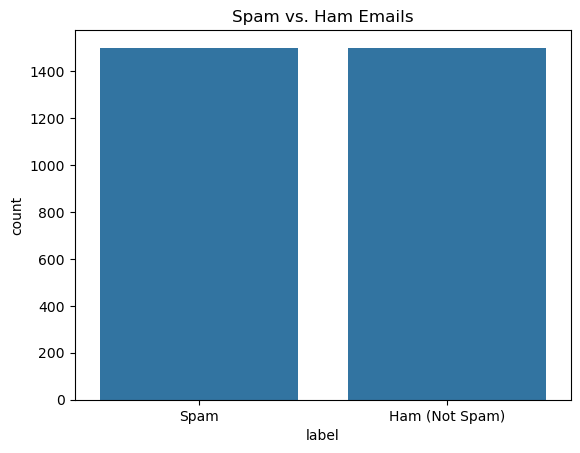

In [4]:
# Separate spam & ham into 2 separate dataframes
spam_msg = data[data['label'] == 'spam']
ham_msg = data[data['label'] == 'ham']

# Balances ham dataset (same size as spam data)
ham_msg_balanced = ham_msg.sample(n = len(spam_msg), random_state = 0)

# Concatenate balanced data
balanced_data = pd.concat([spam_msg, ham_msg_balanced]).reset_index(drop=True)

# Data visualization
sns.countplot(x = 'label', data = balanced_data)
plt.title('Spam vs. Ham Emails')
plt.xticks(ticks = [0,1], labels = ['Spam', 'Ham (Not Spam)'])

In [5]:
# Remove 'Subject: ' from text column bc it doesn't help us classify
balanced_data['text'] = balanced_data['text'].str.replace('Subject: ', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,4685,spam,"photoshop , windows , office . cheap . main tr...",1
1,4185,spam,looking for medication ? we ` re the best sour...,1
2,4922,spam,vocable % rnd - word asceticism\r\nvcsc - bran...,1
3,3799,spam,report 01405 !\r\nwffur attion brom est inst s...,1
4,3948,spam,vic . odin n ^ ow\r\nberne hotbox carnal bride...,1


In [7]:
# Store all punctuations in a list
punctuation_list = string.punctuation

# Remove punctuation from text column
def remove_punctuation(text):
    new = str.maketrans('', '', punctuation_list)
    return text.translate(new)

# For each row in text column, remove punctuation
balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuation(x))

In [8]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    # Empty list of important words
    imp_words = []

    for word in str(text).split():
        word = word.lower()
        
        if word not in stop_words:
            imp_words.append(word)
    
    output = ' '.join(imp_words)
    return output

# In text column, remove stop words + save to the df balanced_data
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))

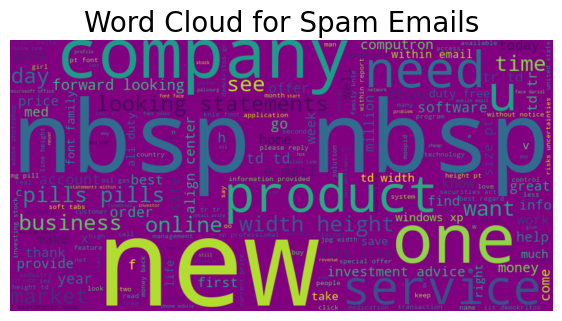

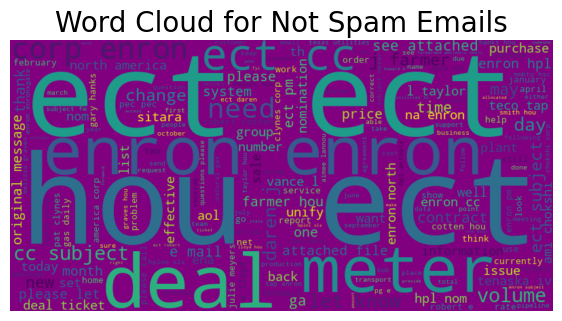

In [9]:
def plot_wc(data, category):
    email_corpus = ' '.join(data['text'])
    wc = WordCloud(width = 800, height = 400, background_color = 'purple').generate(email_corpus)
    plt.figure(figsize = (7, 7))
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(f'Word Cloud for {category} Emails', fontsize = 20)
    plt.axis('off')
    plt.show()

# Plot word clouds for spam & non-spam
plot_wc(balanced_data[balanced_data['label'] == 'spam'], category = 'Spam')
plot_wc(balanced_data[balanced_data['label'] == 'ham'], category = 'Not Spam')

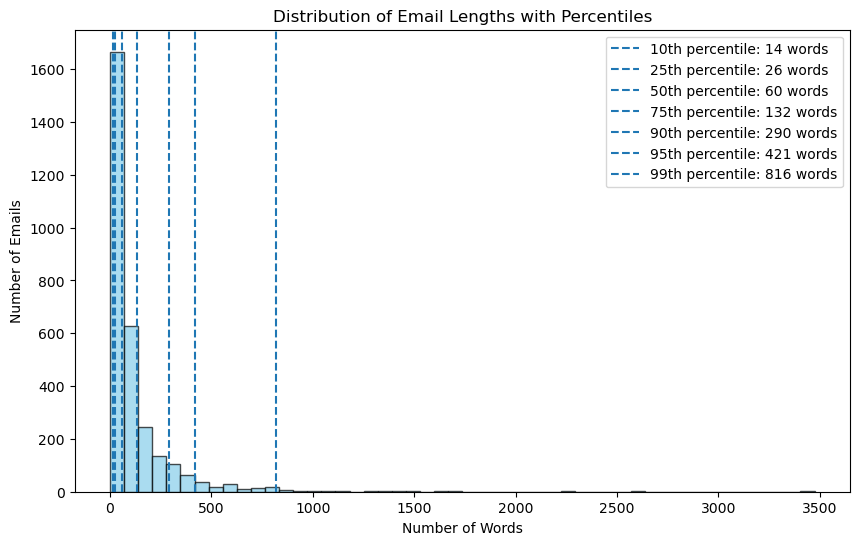

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate lengths of emails in words
email_lengths = balanced_data['text'].apply(lambda x: len(str(x).split()))

# Define desired percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]

# Calculate length values at those percentiles
length_percentiles = email_lengths.quantile([p / 100 for p in percentiles])

# Plot histogram of email lengths
plt.figure(figsize=(10, 6))
plt.hist(email_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Draw vertical lines for each percentile
for p, length in zip(percentiles, length_percentiles):
    plt.axvline(x=length, linestyle='--', label=f'{p}th percentile: {int(length)} words')

plt.title('Distribution of Email Lengths with Percentiles')
plt.xlabel('Number of Words')
plt.ylabel('Number of Emails')
plt.legend()
plt.show()


In [11]:
# Split data into 80% train & 20% test
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size = 0.2, random_state = 42
)

# Tokenization (assigns index integer to each word in train_X)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert each email text to list of numbers (uses tokenizer word -> index dictionary built above)
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
# Pad sequences (ensure all sequences have equal length bc neural networks need equally-sized inputs)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Converts labels to binary (spam = True = 1, ham = False = 0)
train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_len),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# VERSION 3: Bidirectional LSTM with Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    
    Bidirectional(LSTM(64, return_sequences=False)),  # Bidirectional LSTM
    Dropout(0.3),  # Dropout after LSTM
    
    Dense(32, activation='relu'),
    Dropout(0.3),  # Dropout after Dense
    
    Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)


/Users/admin/miniforge3/envs/detect_spam/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-25 10:08:55.569167: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-25 10:08:55.569209: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-25 10:08:55.569240: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-25 10:08:55.569281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-25 10:08:55.569292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <unde

In [14]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32, #32 AT FIRST
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9999 - loss: 7.8871e-04 - val_accuracy: 0.9850 - val_loss: 0.0725 - learning_rate: 1.2500e-04
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9994 - loss: 0.0018 - val_accuracy: 0.9850 - val_loss: 0.0724 - learning_rate: 1.2500e-04
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9990 - loss: 0.0019 - val_accuracy: 0.9850 - val_loss: 0.0725 - learning_rate: 1.2500e-04
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 6.1354e-04 - val_accuracy: 0.9850 - val_loss: 0.0722 - learning_rate: 1.2500e-04


In [15]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9781 - loss: 0.1038
Test Loss : 0.07250431180000305
Test Accuracy : 0.9850000143051147


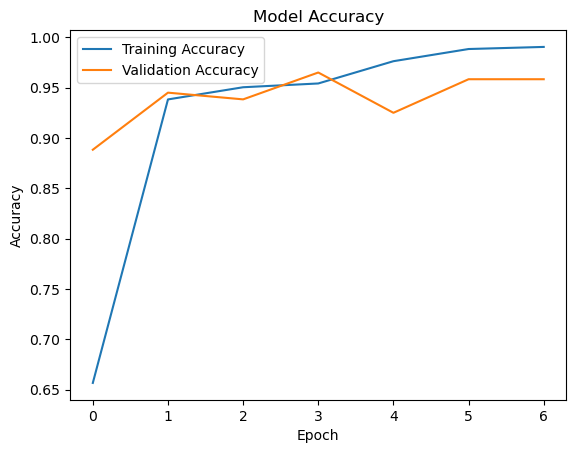

In [29]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()